In [ ]:
from simsopt.geo import create_equally_spaced_curves, curves_to_vtk, SurfaceRZFourier
from simsopt.field import apply_symmetries_to_curves, apply_symmetries_to_currents, Current, ScaledCurrent, Coil, BiotSavart
from simsopt.geo.orientedcurve import OrientedCurveRTPFourier
from simsopt.objectives import SquaredFlux
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from create_surface import *

[Jakes-MacBook-Pro-8.local:57749] shmem: mmap: an error occurred while determining whether or not /var/folders/ng/zysll5xd08qfktm4krnv64lw0000gn/T//ompi.Jakes-MacBook-Pro-8.501/jf.0/1810890752/sm_segment.Jakes-MacBook-Pro-8.501.6bf00000.0 could be created.


In [61]:
field_on_axis = 1.0 # T
fil_distance = 0.05 # distance between dipole filaments for finite coil winding pack [m]
half_per_distance = 0 # distance between dipole panels between half field periods of the device [m]
dipole_radius = 0.05 # radius of dipoles (poloidally constant, will vary toroidally so this is at inboard midplane) [m]

In [3]:
# Create a surface representing the vacuum vessel that dipoles will be placed on
VV_R0 = 1.0
VV_a = 0.3
VV_b = 0.3
VV = SurfaceRZFourier()
VV.set_rc(0,0,VV_R0)
VV.set_rc(1,0,VV_a)
VV.set_zs(1,0,VV_b)
VV_phi = VV.quadpoints_phi
VV_theta = VV.quadpoints_theta

1.002114425480168
0.14219320089544157
7.04755515150861
None


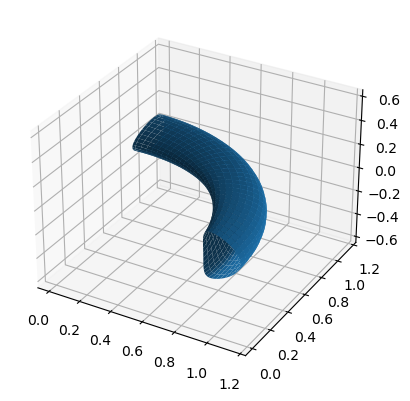

<Axes3D: >

In [ ]:
plas_nPhi = 64                 # toroidal points on plasma surface
plas_nTheta = 64               # poloidal points on plasma surface
surf_s = 1
surf_dof_scale = 1
eq_dir = 'equilibria'
eq_name = 'wout_nfp2ginsburg_000_003186'
eq_name_full = os.path.join(eq_dir, eq_name + '.nc')
surf = create_surface(eq_name_full,'half period', plas_nPhi, plas_nTheta, surf_s, surf_dof_scale, VV_R0)
print(surf.major_radius())
print(surf.minor_radius())
print(surf.aspect_ratio())
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
n = surf.normal()
n_norm = np.linalg.norm(surf.normal(), axis = 2) # used for surface integral calculations
unitn = n * (1./n_norm)[:,:,None]
sqrt_area = np.sqrt(n_norm.reshape((-1,1))/float(n_norm.size))
surf_area = sqrt_area**2
surf.plot(close=True)

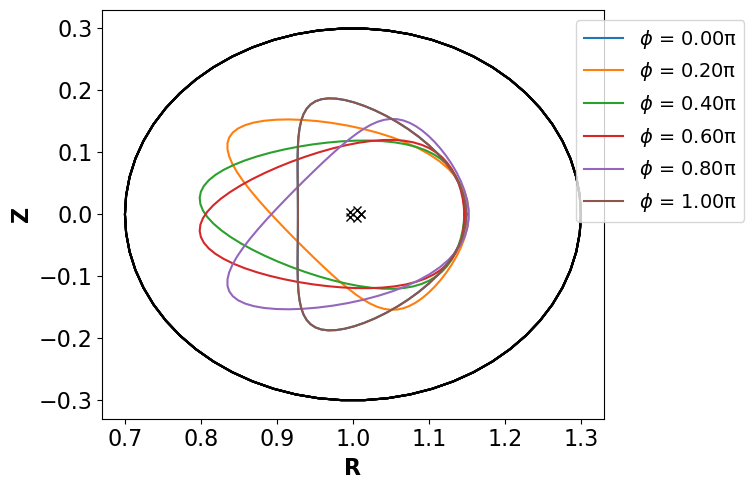

In [5]:
plt.figure(figsize=(8,5))
phi_array = np.arange(0, 1.01, 0.2)
for phi_slice in phi_array:
    cs = surf.cross_section(phi_slice*np.pi)
    rs = np.sqrt(cs[:,0]**2 + cs[:,1]**2); rs = np.append(rs, rs[0])
    zs = cs[:,2]; zs = np.append(zs, zs[0])
    cs2 = VV.cross_section(phi_slice*np.pi)
    rs2 = np.sqrt(cs2[:,0]**2 + cs2[:,1]**2); rs2 = np.append(rs2, rs2[0])
    zs2 = cs2[:,2]; zs2 = np.append(zs2, zs2[0])    
    plt.plot(rs, zs, label=fr'$\phi$ = {phi_slice:.2f}π')
    plt.plot(rs2, zs2, 'k')
    plt.plot(np.mean(rs), np.mean(zs), 'kx')
plt.xlabel('R', fontsize=16, fontweight='bold')
plt.ylabel('Z', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

## Toroidal field coils initialization

In [ ]:
# Generate some TF coils.
ntf = 5
# order is the number of fourier moments to include - we don't need a large value
# 2 should be fine for elliptical
base_toroidal_curves = create_equally_spaced_curves(
    ncurves=ntf,
    nfp=surf.nfp,
    stellsym=surf.stellsym,
    R0=VV_R0,
    R1=VV_a*1.6, # HBT is 0.4m/0.25m = 1.6, so keep this for now? 
    order=2, 
    numquadpoints=32
)

# We define the currents with 1A, so that our dof is order unity. We
# then scale the current by a scale_factor of 1E6.
base_toroidal_current = [Current(1) for c in base_toroidal_curves]
mu0 = 4.0 * np.pi * 1e-7
# toroidal solenoid approximation - B_T = mu0 * I * N / L = mu0 * I * N / L
# therefore, TF current = B_T * 2 * pi * R0 / mu0 / (2 * nfp * n_tf), n_tf = # per half field period!
poloidal_current = -2.0*np.pi*surf.get_rc(0,0)*field_on_axis/mu0
scale_factor = -poloidal_current/(2*ntf*surf.nfp)
base_toroidal_coils = [Coil(curve, ScaledCurrent(current, scale_factor)) for curve, current in zip(base_toroidal_curves, base_toroidal_current)]

## Windowpane coils initialization

We will initialize an array of dipole coils equally spaced in theta and phi on a vacuum vessel.

In [ ]:
# this section creates a dipole array packed into a hexagonal formation
# they will be circular at the inboard midplane, and will increase in toroidal
# length toward the outboard side due to the R dependence of the Jacobian
numquadpoints=32
order = 1
# use this to evenly space coils on elliptical grid
# since evenly spaced in poloidal angle won't work
# must use quadrature for elliptic integral
def generate_even_arc_angles(a, b, ntheta):
    from scipy.integrate import quad
    from scipy.optimize import root_scalar
    def arc_length_diff(theta):
        return np.sqrt((a * np.sin(theta))**2 + (b * np.cos(theta))**2)
    # Total arc length of the ellipse
    total_arc_length, _ = quad(arc_length_diff, 0, 2 * np.pi)
    arc_lengths = np.linspace(0, total_arc_length, ntheta, endpoint=False)
    def arc_length_to_theta(theta, s_target):
        s, _ = quad(arc_length_diff, 0, theta)
        return s - s_target
    # Solve for theta corresponding to each arc length
    thetas = np.zeros(ntheta)
    for i, s in enumerate(arc_lengths):
        if i != 0:
            result = root_scalar(arc_length_to_theta, args=(s,), bracket=[thetas[i-1], 2*np.pi])
            thetas[i] = result.root
    return thetas, total_arc_length

# Poloidal direction
_, total_arc_length = generate_even_arc_angles(VV_a, VV_b, 1) # get total arc length
npol = int(total_arc_length / (2 * dipole_radius + fil_distance)) # figure out how many poloidal dipoles can fit for target radius
Rpol = total_arc_length / 2 / npol - fil_distance / 2 # adjust the poloidal length based off npol to fix filament distance
thetas, _ = generate_even_arc_angles(VV_b, VV_a, npol) # why do a and b need to be switched here? Def a bug, but works? 
dtheta = np.diff(np.append(thetas, 2*np.pi)) / 2 

# Toroidal direction
# Due to spacing in between half field periods, equation governing toroidal dipoles will be:
# D + 2Rtor(theta) + sqrt(3)(ntor - 1)(Rtor(theta) + d/2) = pi/nfp*(R0+r(theta)cos(theta))
# where D is half period spacing of dipoles, d is the distance between filaments, ntor is number of toroidal dipoles, and Rtor is the toroidal radius
# toroidal distance between centers in hexagonal packing = sqrt(3) * (Rdip + fil_distance/2) (i.e. 30-60-90 triangle)
# Set ntor based on the number of circular dipoles that can fit on the inboard side
ntor = int((np.pi/surf.nfp*(VV_R0-VV_a) - half_per_distance - dipole_radius)/np.sqrt(3)/(dipole_radius+fil_distance/2)) + 1

base_wp_curves = []
for ii in range(ntor):
    for jj in range(npol):
        # handle the poloidal angle offsets needed for hexagonal packing
        if (ii % 2 == 1):
            theta_coil = thetas[jj] + dtheta[jj]
        else:
            theta_coil = thetas[jj]
        # see orientedcurve.py for where r/x_int come from/how they're used
        r = VV_a*VV_b / np.sqrt((VV_b*np.cos(theta_coil))**2 + (VV_a*np.sin(theta_coil))**2)
        x_int = r * np.cos(theta_coil) * (1 - VV_b**2/VV_a**2)
        # increase toroidal length to keep filament distance constant in toroidal geometry
        # NOTE: Rtor is the physical width of the dipole, scale is a correction due to implementation specifics and is not physical
        # scale offsets the R dependence of the Jacobian that messes with toroidal width in the cartesian->toroidal transformation
        Rtor = (np.pi/surf.nfp*(VV_R0 + r * np.cos(theta_coil)) - half_per_distance - np.sqrt(3) * (ntor-1) * fil_distance/2) / (2 + np.sqrt(3) * (ntor - 1))
        scale = (VV_R0 + x_int + np.sqrt((r*np.cos(theta_coil) - x_int)**2 + (r*np.sin(theta_coil))**2)) / (VV_R0 + r*np.cos(theta_coil))
        # calculate toroidal angle of center of coil
        dphi = (half_per_distance/2 + Rtor) / (VV_R0 + r * np.cos(theta_coil)) # need to add buffer in phi for gaps in panels
        phi_coil = dphi + ii * (np.sqrt(3) * (Rtor + fil_distance/2)) / (VV_R0 + r * np.cos(theta_coil))
        c = OrientedCurveRTPFourier( numquadpoints, order)
        c.set('yc(1)',Rtor*scale) # toroidal direction
        c.set('zs(1)',Rpol) # poloidal direction
        c.set('R0', VV_R0)
        c.set('a', VV_a)
        c.set('b', VV_b)
        c.set('phi', phi_coil)
        c.set('theta', theta_coil)
        base_wp_curves.append( c )

nwptot = len(base_wp_curves * 2 * surf.nfp)
base_wp_current = [Current(1) for c in base_wp_curves]
wp_scale_factor = 1E5 # Initialize coils at 100kA (reasonable guess for 1T field)
base_wp_coils = [Coil(curve, ScaledCurrent(current, wp_scale_factor)) for curve, current in zip(base_wp_curves, base_wp_current)]
base_coils = base_toroidal_coils + base_wp_coils

## Windowpane Coil Optimization 

In [8]:
# determine if local or normalized definition of quadratic flux is used
# ONLY ONE CAN BE TRUE (if both false, uses standard definition)
local = True
normalized = False

In [17]:
# set the optimization number
opt_num = input("Input Optimization Number (for directory naming): ")

In [13]:
# add anything extra to directory name
extra = input("Anything to add to directory folder name? :")

In [ ]:
# save the output files
if local:
    dir = 'opt_' + str(opt_num) + '_BSspeeduplocal_nt_' + str(ntor) + '_np_' + str(npol) + '_diprad_' + str(np.round(dipole_radius, 2)) + extra
elif normalized:
    dir = 'opt_' + str(opt_num) + '_BSspeedupnormalized_nt_' + str(ntor) + '_np_' + str(npol) + '_diprad_' + str(np.round(dipole_radius, 2)) + extra
else: 
    dir = 'opt_' + str(opt_num) + '_BSspeedup_nt_' + str(ntor) + '_np_' + str(npol) + '_diprad_' + str(np.round(dipole_radius, 2)) + extra

try: 
    os.mkdir(dir)
except OSError as error:  
    print(error)  

In [15]:
with open(dir + "/readme.txt", "w") as file:
    file.write(input("What is special/notable about this optimization (write in the readme file): "))

In [9]:
# we aren't shape optimizing - fix the coil geometry
for c in base_coils:
    c.curve.fix_all()

In [10]:
# fix the currents in some TF coils (so that we avoid the trivial solution), choose either 1 or ntf
num_fixed = 1
for i in range(num_fixed):
    base_coils[i].current.fix_all()

In [11]:
# I have to do this because the dofs are out of order and sorted like current18, current19, 2, 20... 29, 3, 30 etc. , this should fix them
# This might get messed up if I start naming currents - don't do that
ndofs = len(base_coils) - num_fixed
# Create the array of numbers in numerical order (thanks chatGPT)
numbers = list(range(1+num_fixed, ndofs + num_fixed + 1))
# Convert each number to a string
string_numbers = [str(num) for num in numbers]
# Sort the list of strings lexicographically
sorted_string_numbers = sorted(string_numbers)
# Convert back to integers if needed
sorted_indices = [int(num) for num in sorted_string_numbers]

In [ ]:
BdotNcoil = np.zeros((ndofs, plas_nPhi, plas_nTheta))
BdotNcoil_fixed = np.zeros((num_fixed, plas_nPhi, plas_nTheta))
if (local or normalized):
    Bcoil = np.zeros((ndofs, plas_nPhi, plas_nTheta, 3))
    Bcoil_fixed = np.zeros((num_fixed, plas_nPhi, plas_nTheta, 3))

# now we will apply symmetries to the coils one at a time and calculate their respective BdotN contribution
coils = []

# need to add the fixed coil to the BdotN calc even though it isn't a dof
for ii, c  in enumerate(base_coils[0:num_fixed]):
    paired_curves_fixed = apply_symmetries_to_curves(base_curves=[c.curve], nfp=surf.nfp, stellsym=surf.stellsym)
    paired_currents_fixed = apply_symmetries_to_currents(base_currents=[c.current], nfp=surf.nfp, stellsym=surf.stellsym)
    paired_coils_fixed = [Coil(curve, current) for curve, current in zip(paired_curves_fixed, paired_currents_fixed)]
    bs_fixed = BiotSavart(paired_coils_fixed)
    bs_fixed.set_points(surf.gamma().reshape((-1,3)))
    BdotNcoil_fixed[ii, :, :] = np.sum(bs_fixed.B().reshape((plas_nPhi, plas_nTheta, 3)) * surf.unitnormal(), axis = 2) # this is BdotN for the unfixed coil
    if (local or normalized):
        Bcoil_fixed[ii, :, :, :] = bs_fixed.B().reshape((plas_nPhi, plas_nTheta, 3))
    coils += paired_coils_fixed

# precompute normal field from coils at initial current, which just gets scaled up/down during optization
for ii, c  in enumerate(base_coils[num_fixed:]):
    paired_curves = apply_symmetries_to_curves(base_curves=[c.curve], nfp=surf.nfp, stellsym=surf.stellsym)
    paired_currents = apply_symmetries_to_currents(base_currents=[c.current], nfp=surf.nfp, stellsym=surf.stellsym)
    paired_coils = [Coil(curve, current) for curve, current in zip(paired_curves, paired_currents)]
    bs_coil = BiotSavart(paired_coils)
    bs_coil.set_points(surf.gamma().reshape((-1,3)))
    i = sorted_indices.index(ii+1+num_fixed)
    BdotNcoil[i, :, :] = np.sum(bs_coil.B().reshape((plas_nPhi, plas_nTheta, 3)) * surf.unitnormal(), axis = 2) # this is BdotN for each coil
    if (local or normalized):
        Bcoil[i, :, :, :] = bs_coil.B().reshape((plas_nPhi, plas_nTheta, 3))
    coils += paired_coils



In [13]:
# name the coils
for ii in range(0,ntf*2*surf.nfp,2*surf.nfp):
    coils[ii].name = f'TF_coil_{int(ii/(2 * surf.nfp))+1}'

for ii in range(ntf*2*surf.nfp, len(coils), 2*surf.nfp):
    coils[ii].name = f'WP_{int(ii/(2 * surf.nfp))+1-ntf}'

In [14]:
bs = BiotSavart(coils)
Jf = SquaredFlux(surf, bs) # we do this through BdotN now, just using this to get dofs
dofs = Jf.x

In [ ]:
# this should be a surface integral, int(f dS) = int(f|n| dtheta dphi)
def surf_int(f, n_norm, theta, phi):
    return simpson(simpson(f * n_norm, theta), phi)
# not 100% sure if I need this, but does surface integral with 3D array f
def surf_int_3D(f, n_norm, theta, phi): 
    return simpson(simpson(f * n_norm[None,:,:], theta), phi)

In [ ]:
# differentiates between dipole and TF currents
def classify_current(item, threshold):
    # Extract the number after 'Current' and before ':'
    current_num = int(item.split(':')[0].replace('Current', ''))
    # Return 0 if the number is less than threshold, otherwise return 1
    return 0 if current_num < threshold else 1

In [ ]:
# defines derivative of current penalty objective
def derivativeJcp(current, CURRENT_THRESHOLD):
    diff = np.abs(current) - CURRENT_THRESHOLD
    mask = diff > 0
    grad = np.where(current > 0, 2 * (current - CURRENT_THRESHOLD), 2 * (current + CURRENT_THRESHOLD))
    return grad * mask

In [ ]:
# Number of iterations to perform:
MAXITER = 1000

# Current penality threshold and weight
CURRENT_THRESHOLD = 1E7
CURRENT_WEIGHT = 1E-5
#use this to only set dJ for dipole current dofs
dJscale = [classify_current(dof_name, ntf+1) for dof_name in Jf.dof_names]


def fun(dofs):
    BdotN = np.sum(dofs[:,None,None]*BdotNcoil, axis=0) + np.sum(BdotNcoil_fixed, axis=0)
    # this is quadratic flux, J = 0.5 * integral(BdotN^2)ds
    BdotN2 = 0.5 * surf_int(BdotN**2, n_norm, theta, phi) 
    gradBdotN2 = surf_int(BdotNcoil * BdotN[None,:,:],n_norm, theta, phi)
    BdotNavg = np.mean(np.abs(BdotN))
    # this is a hardcoded current threshold penalty
    Jcp = np.sum(dJscale*np.array([np.maximum(np.abs(dofs[i]*wp_scale_factor) - CURRENT_THRESHOLD, 0)**2 for i in range(len(dofs))]))
    dJcp = dJscale * np.array([derivativeJcp(dofs[i]*wp_scale_factor, CURRENT_THRESHOLD) for i in range(len(dofs))])
    outstr = f"Jcp + BdotN2={CURRENT_WEIGHT * Jcp + BdotN2:.1e}, Jcp ={Jcp:.1e}, ⟨B·n⟩={BdotNavg:.1e}"
    print(outstr)
    J = CURRENT_WEIGHT * Jcp + BdotN2
    grad = CURRENT_WEIGHT * dJcp + gradBdotN2
    return J, grad

def fun_local(dofs):
    B = np.sum(dofs[:,None,None,None]*Bcoil, axis=0) + np.sum(Bcoil_fixed, axis=0)
    BdotN = np.sum(dofs[:,None,None]*BdotNcoil, axis=0) + np.sum(BdotNcoil_fixed, axis=0)
    modB = np.linalg.norm(B, axis=2)
    BcoildotB = np.sum(Bcoil * B, axis = 3)
    # this is local quadratic flux, J = 0.5 * integral(BdotN^2/modB^2)ds
    BdotN2 = 0.5 * surf_int((BdotN / modB)**2, n_norm, theta, phi)
    gradBdotN2 = surf_int_3D((modB[None, :, :]**2 * BdotNcoil * BdotN[None,:,:] - BcoildotB * BdotN[None,:,:]**2) / modB[None, :, :]**4, n_norm, theta, phi)
    BdotNavg = np.mean((np.abs(BdotN/modB)))
    # this is a hardcoded current threshold penalty only on the dipoles
    Jcp = np.sum(dJscale*np.array([np.maximum(np.abs(dofs[i]*wp_scale_factor) - CURRENT_THRESHOLD, 0)**2 for i in range(len(dofs))]))
    dJcp = dJscale * np.array([derivativeJcp(dofs[i]*wp_scale_factor, CURRENT_THRESHOLD) for i in range(len(dofs))])
    outstr = f"Jcp + BdotN2={CURRENT_WEIGHT * Jcp + BdotN2:.1e}, Jcp ={Jcp:.1e}, ⟨(B·n)/B⟩={BdotNavg:.1e}"
    print(outstr)
    J = CURRENT_WEIGHT * Jcp + BdotN2
    grad = CURRENT_WEIGHT * dJcp + gradBdotN2
    return J, grad

def fun_normalized(dofs):
    B = np.sum(dofs[:,None,None,None]*Bcoil, axis=0) + np.sum(Bcoil_fixed, axis=0)
    BdotN = np.sum(dofs[:,None,None]*BdotNcoil, axis=0) + np.sum(BdotNcoil_fixed, axis=0)
    modB = np.linalg.norm(B, axis=2)
    BcoildotB = np.sum(Bcoil * B, axis = 3)
    # this is normalized quadratic flux, J = 0.5 * integral(BdotN^2)ds / integral(modB^2)ds
    BdotN2 = 0.5 * surf_int(BdotN**2, n_norm, theta, phi) /  surf_int(modB**2, n_norm, theta, phi)
    gradBdotN2 = (surf_int_3D(modB[None, :, :]**2, n_norm, theta, phi) * surf_int_3D(BdotNcoil * BdotN[None,:,:], n_norm, theta, phi) - surf_int_3D(BcoildotB, n_norm, theta, phi) * surf_int_3D(BdotN[None,:,:]**2, n_norm, theta, phi)) / surf_int_3D(modB[None, :, :]**2 , n_norm, theta, phi)**2
    BdotNavg = np.mean((np.abs(BdotN/modB)))
    # this is a hardcoded current threshold penalty
    Jcp = np.sum(dJscale*np.array([np.maximum(np.abs(dofs[i]*wp_scale_factor) - CURRENT_THRESHOLD, 0)**2 for i in range(len(dofs))]))
    dJcp = dJscale * np.array([derivativeJcp(dofs[i]*wp_scale_factor, CURRENT_THRESHOLD) for i in range(len(dofs))])
    outstr = f"JF + BdotN2={CURRENT_WEIGHT * Jcp + BdotN2:.1e}, Jcp ={Jcp:.1e}, ⟨(B·n)/B⟩={BdotNavg:.1e}"
    print(outstr)
    J = CURRENT_WEIGHT * Jcp + BdotN2
    grad = CURRENT_WEIGHT * dJcp + gradBdotN2
    return J, grad

Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02


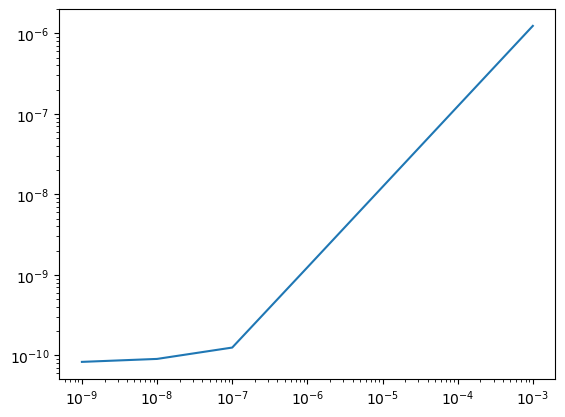

In [19]:
# Taylor test
if local:
    f = fun_local
elif normalized:
    f = fun_normalized
else:
    f = fun
dofs = Jf.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
eps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
err = np.zeros([len(eps)])
for i, ep in enumerate(eps):
    J1, _ = f(dofs + ep*h)
    J2, _ = f(dofs)
    err[i] = np.abs((J1-J2)/(ep) - dJh)
    #print("ep", ep, "err", err[i])

plt.figure()
plt.loglog(eps, err)

Initial Average BdotN / |B|: 0.059415208700553925


Text(0.5, 0, '$\\phi$')

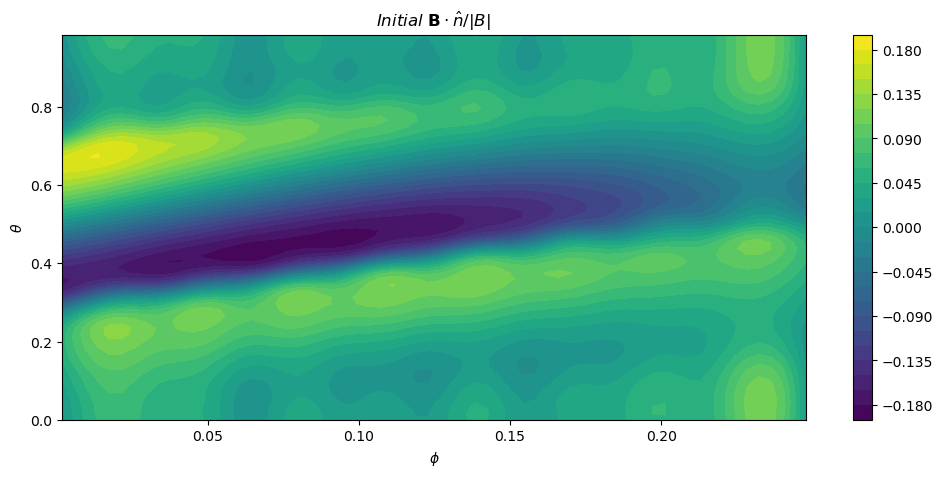

In [21]:
Bdotn = np.sum(bs.B().reshape((plas_nPhi, plas_nTheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((plas_nPhi,plas_nTheta))
BdotN_norm = Bdotn / modB
abs_relBfinal_norm_dA = np.abs(BdotN_norm.reshape((-1, 1))) * surf_area
mean_abs_relBfinal_norm = np.sum(abs_relBfinal_norm_dA) / np.sum(surf_area)

print('Initial Average BdotN / |B|: ' + str(mean_abs_relBfinal_norm))
initial_avgBdotN2 = mean_abs_relBfinal_norm
initial_maxBdotN2 = np.max(np.abs(BdotN_norm))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(phi,theta,np.transpose(Bdotn / modB), 25)
plt.colorbar(c)
ax.set_title(r'$Initial ~\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\theta$')
ax.set_xlabel(r'$\phi$')
#plt.savefig(dir + '/InitialBdotN')

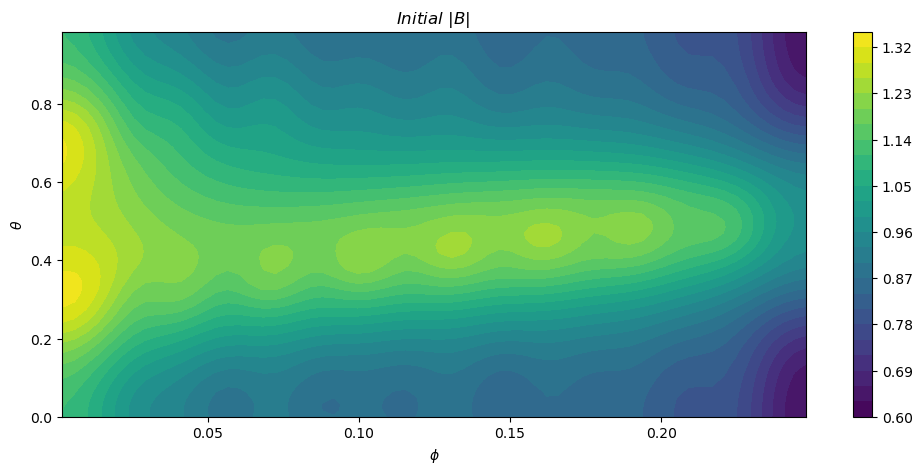

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(phi,theta,np.transpose(modB), 25)
ax.set_title(r'$Initial ~ |B|$ ')
ax.set_ylabel(r'$\theta$')
ax.set_xlabel(r'$\phi$')
plt.colorbar(c)
#plt.savefig(dir + '/InitialModB')
initial_modBavg = np.mean(modB)

In [23]:
if local:
    res = minimize(fun_local, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-8)
elif normalized:
    res = minimize(fun_normalized, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-8)
else:
    res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-8)

Jcp + BdotN2=3.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=6.3e-02
Jcp + BdotN2=2.9e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=5.2e-02
Jcp + BdotN2=2.6e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=4.9e-02
Jcp + BdotN2=2.3e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=4.5e-02
Jcp + BdotN2=1.8e-03, Jcp =0.0e+00, ⟨(B·n)/B⟩=3.8e-02
Jcp + BdotN2=9.8e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=2.9e-02
Jcp + BdotN2=9.5e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=2.8e-02
Jcp + BdotN2=7.1e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=2.5e-02
Jcp + BdotN2=5.4e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=2.1e-02
Jcp + BdotN2=4.2e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.9e-02
Jcp + BdotN2=3.4e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.7e-02
Jcp + BdotN2=3.0e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.5e-02
Jcp + BdotN2=2.2e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.3e-02
Jcp + BdotN2=1.8e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.2e-02
Jcp + BdotN2=1.5e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.1e-02
Jcp + BdotN2=1.4e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=1.0e-02
Jcp + BdotN2=1.2e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=9.9e-03
Jcp + BdotN2=1.1e-04, Jcp =0.0e+00, ⟨(B·n)/B⟩=9.5e-03
Jcp + BdotN2=1.0e-04, Jcp =0

In [24]:
# this tells you why the optimization stopped
message = res.message
print(message)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [25]:
#update currents in the coils
Jf.x = res.x

Final Integrated BdotN / |B|: 0.0032198184206857073


Text(0.5, 0, '$\\phi$')

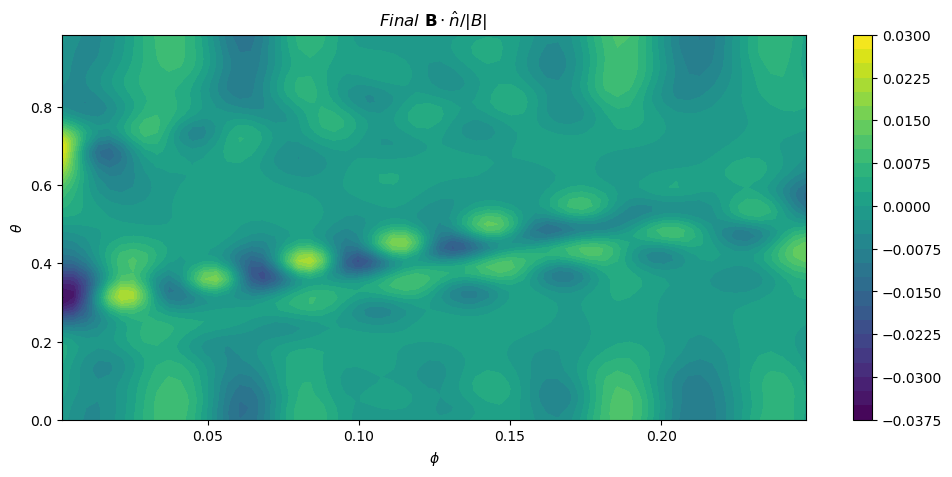

In [26]:
Bdotn = np.sum(bs.B().reshape((plas_nPhi, plas_nTheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((plas_nPhi,plas_nTheta))
BdotN_norm = Bdotn / modB
abs_relBfinal_norm_dA = np.abs(BdotN_norm.reshape((-1, 1))) * surf_area
mean_abs_relBfinal_norm = np.sum(abs_relBfinal_norm_dA) / np.sum(surf_area)

print('Final Integrated BdotN / |B|: ' + str(mean_abs_relBfinal_norm))
final_avgBdotN2 = mean_abs_relBfinal_norm
final_maxBdotN2 = np.max(np.abs(BdotN_norm))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(phi,theta,np.transpose(Bdotn / modB),25)
plt.colorbar(c)
ax.set_title(r'$Final ~\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\theta$')
ax.set_xlabel(r'$\phi$')
#plt.savefig(dir + '/FinalBdotN')

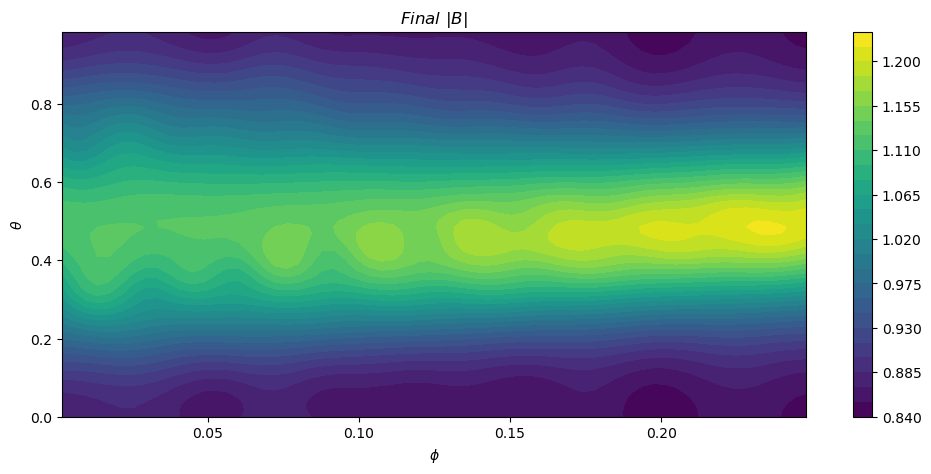

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(phi,theta,np.transpose(modB), 25)
ax.set_title(r'$Final ~ |B|$ ')
ax.set_ylabel(r'$\theta$')
ax.set_xlabel(r'$\phi$')
plt.colorbar(c)
#plt.savefig(dir + '/FinalModB')
final_modBavg = np.mean(modB)

In [84]:
with open(dir + "/coilcurrents.txt", "w") as file0:
    for ii, c in enumerate(coils[0:-1:2*surf.nfp]):
        file0.write(f"{c.name} has current = {c.current.get_value():.2E} \n")

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

In [ ]:
currents = [coils[i].current.get_value() for i in range(len(coils))]
# B field of an circle = mu0 I / 2 R
B_fields = [mu0 * base_wp_coils[i].current.get_value() / 2 / Rpol for i in range(len(base_wp_coils))]
print("Number of saddles", nwptot)
max_It = np.max([coils[i].current.get_value() for i in range(ntf*2*surf.nfp)])
max_Iwp = np.max([coils[i].current.get_value() for i in range(ntf*2*surf.nfp, len(coils))])
mean_It = np.mean([np.abs(coils[i].current.get_value()) for i in range(ntf*2*surf.nfp)])
mean_Iwp = np.mean([np.abs(coils[i].current.get_value()) for i in range(ntf*2*surf.nfp, len(coils))])
print("Ratio of max toroidal current to max saddle current", max_It/max_Iwp)
print("Ratio of mean toroidal current to max saddle current", mean_It/mean_Iwp)

Number of saddles 384
Ratio of max toroidal current to max saddle current 0.5741175058428799
Ratio of mean toroidal current to max saddle current 3.291017174011691


In [30]:
# save the output files
curves = [c.curve for c in coils]
surf.to_vtk('surf_opt', extra_data={"B_N": BdotN_norm[:, :, None]})
VV.to_vtk('vacuumvessel')
curves_to_vtk(curves, 'coils', close=True, extra_data={'currents':np.array([current for current in currents for _ in range(numquadpoints+1)])})
#bs.save('biot_savart_opt.json');

In [31]:
surf_full = create_surface(eq_name_full,'full torus', 4*plas_nPhi, plas_nTheta, surf_s, surf_dof_scale, VV_R0)
bs.set_points(surf_full.gamma().reshape(-1,3))
Bdotn = np.sum(bs.B().reshape((4*plas_nPhi, plas_nTheta, 3)) * surf_full.unitnormal(), axis=2)
modB = bs.AbsB().reshape((4*plas_nPhi,plas_nTheta))
BdotN_norm = Bdotn / modB
surf_full.to_vtk('surf_full', extra_data={"B_N": BdotN_norm[:, :, None]})

In [ ]:
# write the optimization readme
lines = ["Dipole Optimization with Normal Biot-Savart\n",
         "Equilibrium file location: " + surf_loc + "\n", 
         "Equilibrium parameters: maximum s = " + str(surf_s) + " and dof scale factor = " + str(surf_dof_scale) + "\n",
         "Number of toroidal field coils per half field period = " + str(ntf) + "\n", 
         "Number of toroidal field coils with fixed current = " + str(num_fixed) + "\n", 
         "Number of dipoles in toroidal direction per half field period = " + str(ntoroidal) + "\n",
         "Number of dipoles in poloidal direction = " + str(npoloidal) + "\n",
         "Total number of dipoles = " + str(nwptot) + "\n",
         "Dipole radius = " + str(dipole_radius) + "\n", 
         "Local definition of quadratic flux?: " + str(local) + "\n",
         "Normalized definition of quadratic flux?: " + str(normalized) + "\n",
         "\n", 
         "Optimization results \n",
         "Why did optimization finish?: " + message + "\n",
         "Initial Integrated BdotN^2 / |B|^2 = " + str(initial_avgBdotN2) + "\n", 
         "Final Integrated BdotN^2 / |B|^2 = " + str(final_avgBdotN2) + "\n",
         "Initial Max BdotN^2 / |B|^2 = " + str(initial_maxBdotN2) + "\n", 
         "Final Max BdotN^2 / |B|^2 = " + str(final_maxBdotN2) + "\n",
         "Initial Average |B| = " + str(initial_modBavg) + "\n", 
         "Final Average |B| = " + str(final_modBavg) + "\n",
         "Ratio of max toroidal current to max dipole current = " + str(max_It/max_Iwp) + "\n", 
         "Ratio of mean toroidal current to max dipole current = " + str(mean_It/mean_Iwp) + "\n"]
 
with open(dir + "/parameters.txt", "w") as file1:
    file1.writelines(lines)

# 